# Basics of reading an MRC file with 4D STEM data from the Spectra300 at UTK
## By Austin Houston
### Last updated 2024-09-03

In [1]:
import os
import time
from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt

import h5py
import mrcfile

import sidpy

In [2]:
%matplotlib ipympl

In [3]:
mrc_filepath = '/Users/austin/Dropbox/GaTech_colabs/ScFeO3_Al2O3/2024_07_03/4D_stem/'

save_path = '/Users/austin/Dropbox/GaTech_colabs/ScFeO3_Al2O3/2024_07_03/4D_h5_files/'

In [4]:
mrc_files = os.listdir(mrc_filepath)
mrc_files = [f for f in mrc_files if f.endswith('.mrc')]
mrc_files = sorted(mrc_files)


In [5]:
mrc_raw =  mrcfile.open(mrc_filepath+mrc_files[1], permissive=True)

# Read the file
extended_header = mrc_raw.indexed_extended_header
metadata_labels = extended_header.dtype.names
metadata_labels = [label for label in metadata_labels]

mrc_data = mrc_raw.data

# Reshape the data
shape_cantidates = ['Scan size right', 'Scan size left', 'Scan size top', 'Scan size bottom']

sizes = []
for label in shape_cantidates:
    size = np.unique(extended_header[label])
    sizes.append(size)

# this part is a little confusing
# do we reshape L-R or T-B?
# the following is a guess
x_shape = int(np.abs(sizes[0] - sizes[1]))
y_shape = int(np.abs(sizes[2] - sizes[3]))
reshape_target = (x_shape, y_shape, mrc_data.shape[-2], mrc_data.shape[-1])
reshaped_data = np.reshape(mrc_data, reshape_target)

# Get these 'pixel sizes' are usually in the order of 10^8
# is this the ceta pixel size?...
# what are the units?
pixel_sizes = []
for label in ['Pixel size X', 'Pixel size Y']:
    size = np.unique(extended_header[label])
    pixel_sizes.append(size)

# get real space pixel sizes a different way
# but this results in different pixel sizes by ~0.01 Angstroms
# incorrect?
step_x  = np.unique(extended_header['Full scan FOV X']) / x_shape * 1e10 # Angstroms
step_y  = np.unique(extended_header['Full scan FOV Y']) / y_shape * 1e10 # Angstroms
    



/var/folders/1h/36qxtl8567zdjv8nzdn4fzrr0000gn/T/ipykernel_442/3194067291.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_shape = int(np.abs(sizes[0] - sizes[1]))
/var/folders/1h/36qxtl8567zdjv8nzdn4fzrr0000gn/T/ipykernel_442/3194067291.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_shape = int(np.abs(sizes[2] - sizes[3]))


In [6]:
for label in metadata_labels:
    print(label, np.unique(extended_header[label]))

Metadata size [888]
Metadata version [2]
Bitmask 1 [49185]
Timestamp [45476.95348159 45476.9534819  45476.9534822  ... 45476.95412522
 45476.95412553 45476.95412583]
Microscope type [b'']
D-Number [b'']
Application [b'']
Application version [b'']
HT [300000.]
Dose [0.]
Alpha tilt [0.]
Beta tilt [0.]
X-Stage [0.]
Y-Stage [0.]
Z-Stage [0.]
Tilt axis angle [0.]
Dual axis rotation [0.]
Pixel size X [4.3988768e+08]
Pixel size Y [4.3988768e+08]
Unused range [b'']
Defocus [0.]
STEM Defocus [0.]
Applied defocus [0.]
Instrument mode [0]
Projection mode [0]
Objective lens mode [b'']
High magnification mode [b'']
Probe mode [0]
EFTEM On [False]
Magnification [0.]
Bitmask 2 [15728641]
Camera length [0.07066868]
Spot index [0]
Illuminated area [0.]
Intensity [0.]
Convergence angle [0.]
Illumination mode [b'']
Wide convergence angle range [False]
Slit inserted [False]
Slit width [0.]
Acceleration voltage offset [0.]
Drift tube voltage [0.]
Energy shift [0.]
Shift offset X [0.]
Shift offset Y [0.]
Sh

In [7]:
pixel_sizes

[array([4.3988768e+08]), array([4.3988768e+08])]

In [8]:
print('Pixel size X', 'Pixel size Y')
print(pixel_sizes)

print('Full scan FOV X', 'Full scan FOV Y')
print(np.unique(extended_header['Full scan FOV X']), np.unique(extended_header['Full scan FOV Y']))

print(x_shape, y_shape)
print(step_x, step_y)

Pixel size X Pixel size Y
[array([4.3988768e+08]), array([4.3988768e+08])]
Full scan FOV X Full scan FOV Y
[1.96305274e-08] [1.96305274e-08]
22 92
[8.92296701] [2.13375298]


In [27]:
extended_header['Frame time']

array([0., 0., 0., ..., 0., 0., 0.])

In [24]:
np.unique(extended_header['Frame time']) 

array([0.])

In [26]:
np.unique(extended_header['Dwell time'])

array([0.0263296])

In [9]:
### This is all for saving to file later, not important right now:

In [10]:
# how can I get the pixel sizes? Should be easy for the real space, but how for reciprocal space?
mrc_dset = sidpy.Dataset.from_array(reshaped_data, name='MRC_000', chunks=(1, 1, reshape_target[-2], reshape_target[-1]))

mrc_dset.set_dimension(0, sidpy.Dimension(np.arange(mrc_dset.shape[0])*step_y, 
                                        name='x', units='Angstom', quantity='Length',
                                        dimension_type='spatial'))

mrc_dset.set_dimension(1, sidpy.Dimension(np.arange(mrc_dset.shape[1])*step_x,
                                        name='y', units='Angstrom', quantity='Length',
                                        dimension_type='spatial'))

mrc_dset.set_dimension(2, sidpy.Dimension(np.arange(mrc_dset.shape[2]),
                                        name='u', units='unknown', quantity='angles',
                                        dimension_type='reciprocal'))

mrc_dset.set_dimension(3, sidpy.Dimension(np.arange(mrc_dset.shape[3]),
                                        name='v', units='unknown', quantity='angles',
                                        dimension_type='reciprocal'))

# reading metadata
metadata = {}
for label in metadata_labels:
    # later, we may want to remove 'np.unique()', but I see no problems now
    metadata[label] = np.unique(extended_header[label])

mrc_dset.metadata = metadata

In [11]:
# now this is for a different notebook:
# clustering

In [12]:
from sklearn.cluster import KMeans

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D

from scipy.ndimage import center_of_mass

In [13]:
mrc_dset = mrc_dset[:,:,20:180,40:200]

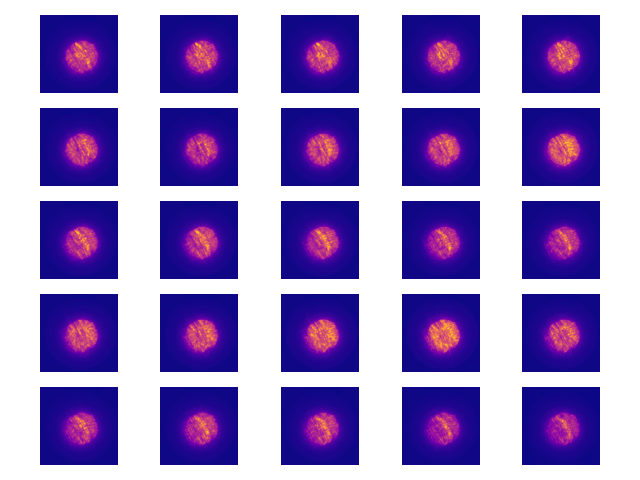

In [14]:
# perform nmf on the data
fig, axs = plt.subplots(5,5)
for i in range(5):
    for j in range(5):
        axs[i,j].imshow(mrc_dset[i,j,:,:], cmap='plasma')
        axs[i,j].axis('off')
fig.tight_layout()

In [15]:
# get COM for all images
coms = np.zeros((mrc_dset.shape[0], mrc_dset.shape[1], 2))

# Compute the center of mass for each image
for i in range(mrc_dset.shape[0]):
    for j in range(mrc_dset.shape[1]):
        coms[i, j] = center_of_mass(mrc_dset[i, j, :, :])

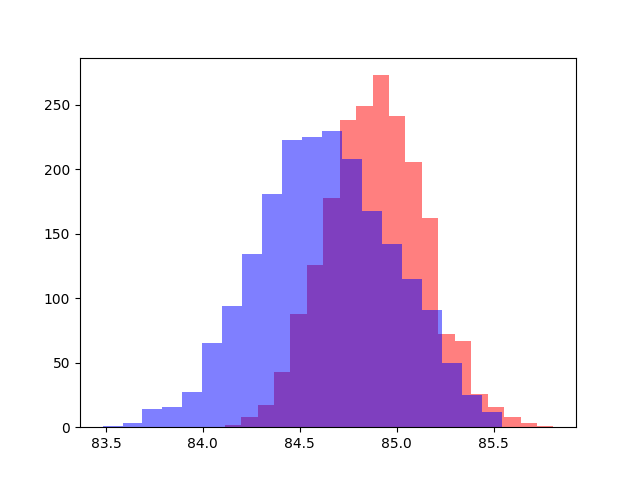

In [16]:
plt.figure()
plt.hist(coms[:,:,0].flatten(), bins=20, color='r', alpha=0.5);
plt.hist(coms[:,:,1].flatten(), bins=20, color='b', alpha=0.5);


In [17]:
mrc_array = np.array(mrc_dset)
N, M, height, width = mrc_dset.shape
datacube_flat = mrc_array.reshape(N * M, -1)

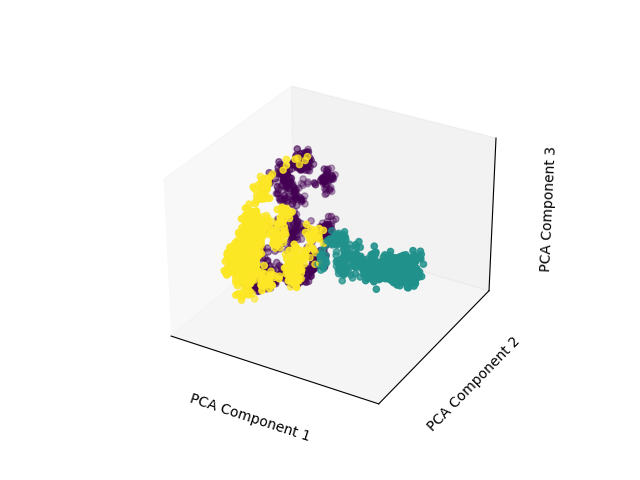

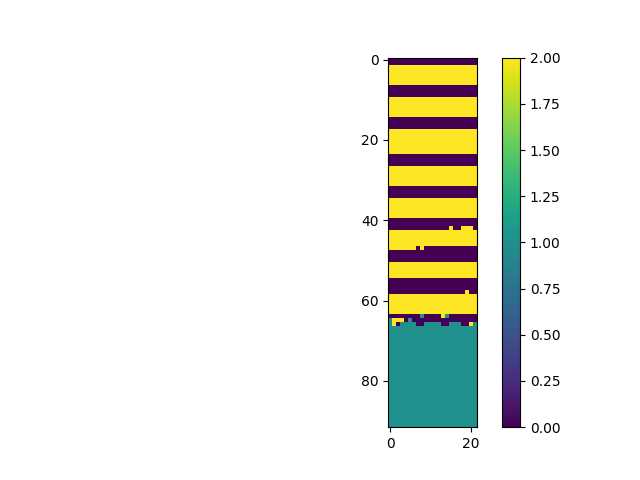

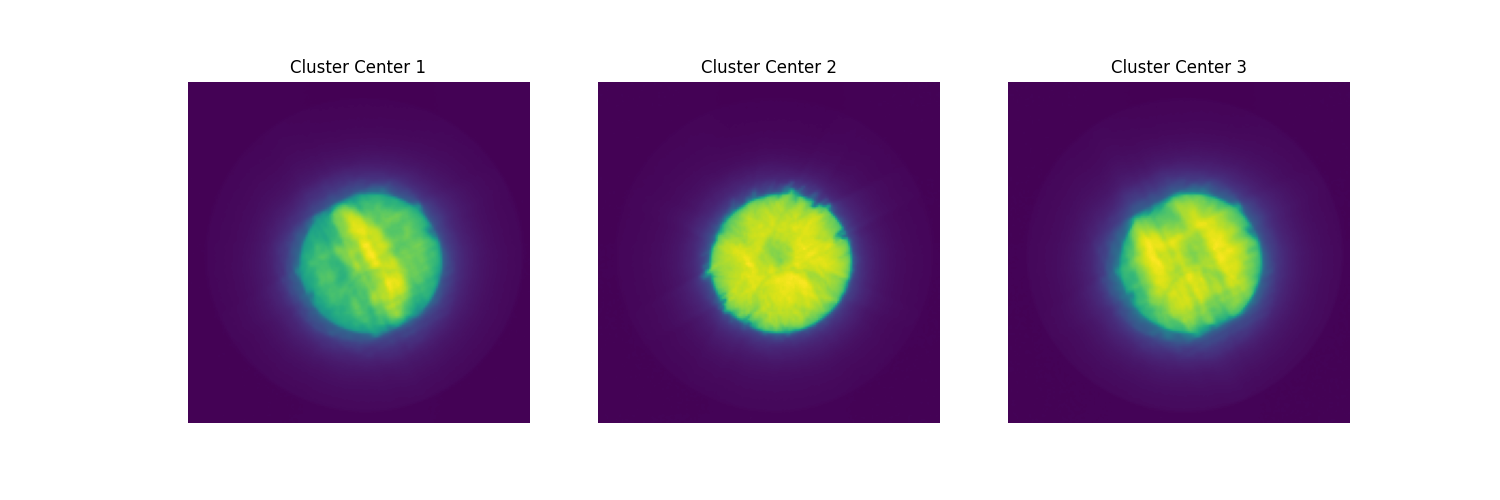

In [18]:
# Perform KMeans clustering
clusters = 3 
kmeans = KMeans(n_clusters=clusters, random_state=0).fit(datacube_flat)
labels = kmeans.labels_
cluster_centers = kmeans.cluster_centers_

# Reduce the data to 3D using PCA
pca = PCA(n_components=3)
datacube_reduced = pca.fit_transform(datacube_flat)
cluster_centers_reduced = pca.transform(cluster_centers)

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(datacube_reduced[:, 0], datacube_reduced[:, 1], datacube_reduced[:, 2], c=labels, cmap='viridis', marker='o')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
plt.show()


label_image = labels.reshape((M, N))

plt.figure()
plt.imshow(label_image, cmap='viridis')
plt.colorbar()
plt.show()

# Reshape cluster centers back to original image dimensions
cluster_center_images = cluster_centers.reshape((kmeans.n_clusters, height, width))

# Plot the average images
fig, axes = plt.subplots(1, kmeans.n_clusters, figsize=(15, 5))

for i, ax in enumerate(axes):
    ax.imshow(cluster_center_images[i], cmap='viridis')
    ax.set_title(f'Cluster Center {i+1}')
    ax.axis('off')

plt.show()

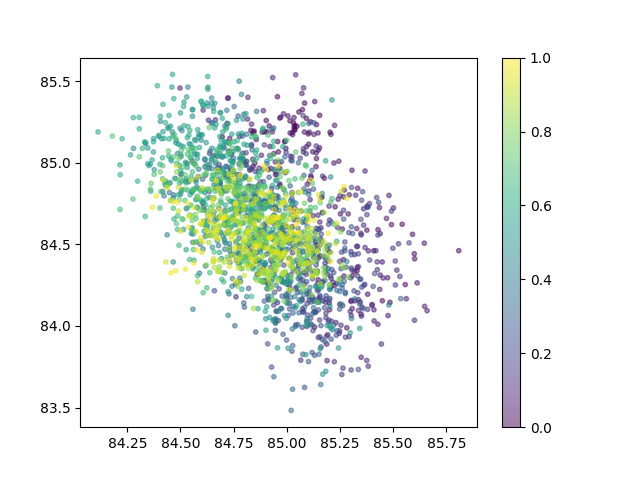

In [19]:
flattened_coms = coms.reshape(-1, 2)
P = flattened_coms.shape[0]
colors = plt.cm.viridis(np.linspace(0, 1, P))

plt.figure()
plt.scatter(flattened_coms[:, 0], flattened_coms[:, 1], c=colors, s=10, alpha=0.5)  # 's' is the size of the points
plt.colorbar()

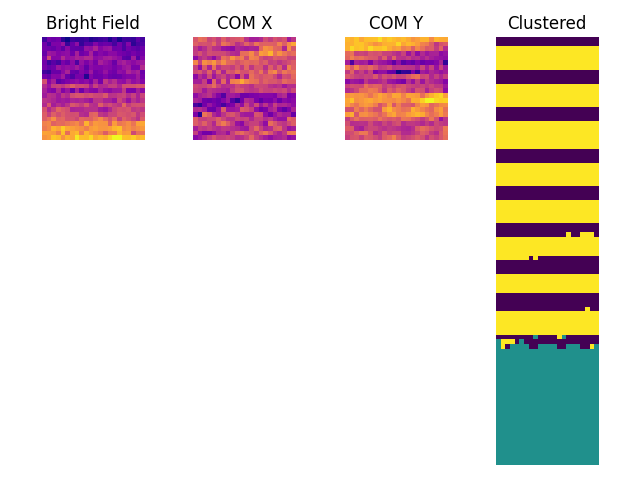

In [20]:
fig, ax = plt.subplots(1,4, sharex=True, sharey=True)

ax[0].imshow(np.sum(mrc_array, axis=(2,3)), cmap='plasma')
ax[0].set_title('Bright Field')

ax[1].set_title('COM X')
ax[1].imshow(coms[:,:,0], cmap='plasma')

ax[2].set_title('COM Y')
ax[2].imshow(coms[:,:,1], cmap='plasma')

ax[3].set_title('Clustered')
ax[3].imshow(label_image, cmap='viridis')

for a in ax:
    a.axis('off')
fig.tight_layout()